<a href="https://colab.research.google.com/github/jake314jake/facial-recognition/blob/main/Global.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**VGG-Face** package

In [ ]:
!pip install git+https://github.com/ma7555/keras-vggface.git mtcnn

# Key words


1.   **VGG-Face**: VGG-Face refers to a specific implementation of a Convolutional Neural Network (CNN) for face recognition, based on the VGGNet architecture
2.   **mtcnn** :  Multi-Task Cascaded Convolutional Networks, is a deep learning-based algorithm designed for face detection and facial feature alignment.
3. **embedding** : the context of machine learning generally refers to a numerical representation of objects or concepts in a lower-dimensional space.(unique features)
4. **HDF5 file**: is a file format and set of tools for managing complex data. It is widely used in the scientific and engineering communities for storing and organizing large amounts of data(h5 extention)
5. **LFW** : LFW stands for "Labeled Faces in the Wild," and it refers to a widely used dataset in the field of face recognition.


# Main functions


1.   **getImage(image_path)** :
Returns the image loaded from the specified file path
2.   **extract_face(image, required_size=(224, 224))**:Returns a list of face arrays and corresponding bounding boxes detected in the input image.
3. **get_embedding(employee_id, face_pixel):** Returns the employee ID (in the system) and the facial embedding using the VGGFace model.
4. **save_embeddings(embeddings_list, file_path="embedding.h5")**: Saves the embeddings to an HDF5 file( embedding store)
5. **load_embeddings(file_path="embedding.h5")**: Loads embeddings from an HDF5 file and returns a dictionary of employee IDs mapped to their embeddings.
6.**build(image_list, labels, hdf5_file_path="embedding.h5")**:
Builds and saves embeddings for the given images and labels.
7. **similarity_function(embedding1, embedding2)**:
Computes and returns the cosine similarity between two embeddings.
8. **verify_person(face_pixels, stored_embeddings, threshold=0.6)**:
Verifies the input face against stored embeddings and returns the verified employee ID and the maximum similarity score.
9. **visualize_verification(image, stored_embeddings)**:
Visualizes the verification results by drawing bounding boxes around faces and displaying the result.




In [3]:
#check "Main function"  section above
import os
import cv2
from mtcnn.mtcnn import MTCNN
from PIL import Image
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from keras_vggface.vggface import VGGFace
from keras_vggface.utils import preprocess_input
import h5py
import matplotlib.pyplot as plt

def getImage(image_path):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return image

def extract_face(image, required_size=(224, 224)):
    detector = MTCNN()
    results = detector.detect_faces(image)
    face_arrays = []
    bounding_boxes = []

    for i, result in enumerate(results):
        x, y, width, height = result['box']
        x2, y2 = x + width, y + height
        face = image[y:y2, x:x2]
        face = Image.fromarray(face)
        face = face.resize(required_size)
        face_array = np.asarray(face)
        face_arrays.append(face_array)

        bounding_boxes.append((x, y, width, height))

    return face_arrays, bounding_boxes

def get_embedding(employee_id, face_pixel):
    sample = np.expand_dims(face_pixel.astype('float32'), axis=0)
    sample = preprocess_input(sample, version=2)
    model = VGGFace(model='resnet50', include_top=False, input_shape=(224, 224, 3), pooling='avg')
    embedding = model.predict(sample)
    return employee_id, embedding


def save_embeddings(embeddings_list, file_path="embedding.h5"):
    try:
        with h5py.File(file_path, 'a') as hf:
            for id, embedding in embeddings_list:
                if id in hf:
                    # Existing dataset, overwrite
                    hf[id][:] = embedding
                else:
                    # Create a new dataset
                    hf.create_dataset(id, data=embedding)
    except Exception as e:
        print(f"Error saving embeddings to HDF5: {e}")

def load_embeddings(file_path="embedding.h5"):
    embeddings = {}
    try:
        with h5py.File(file_path, 'r') as hf:
            for employee_id in hf.keys():
                embedding = np.array(hf[employee_id])
                embeddings[employee_id] = embedding
    except Exception as e:
        print(f"Error loading embeddings from HDF5: {e}")
        return None

    return embeddings


def build(image_list, labels, hdf5_file_path="embedding.h5"):
    if len(image_list) != len(labels):
        print("Error: The number of images and labels must be the same.")
        return

    embedding_data = []

    for i, (image, label) in enumerate(zip(image_list, labels)):
        print(i)
        try:
            face_pixels, _ = extract_face(image)
            if not face_pixels:
                print(f"No face detected in image {i + 1} with label '{label}'. Skipping.")
                continue

            face_id = f"{label}"
            embedding = get_embedding(face_id, face_pixels[0])[1].flatten()

            embedding_data.append((face_id, embedding))
        except Exception as e:
            print(f"Error processing image {i + 1} with label '{label}': {e}")
            continue

    if not embedding_data:
        print("No valid embeddings were generated.")
        return

    save_embeddings(embedding_data, hdf5_file_path)




def similarity_function(embedding1, embedding2):
    normalized_embedding1 = embedding1 / np.linalg.norm(embedding1)
    normalized_embedding2 = embedding2 / np.linalg.norm(embedding2)
    return cosine_similarity([normalized_embedding1], [normalized_embedding2])[0][0]


def verify_person(face_pixels, stored_embeddings , threshold=0.6):
    try:
        result = get_embedding("input_face", face_pixels)
        if result is None or len(result) != 2:
            print("Invalid input face embedding.")
            return None, None

        input_embedding = result[1].flatten()

        #stored_embeddings = load_embeddings("embedding.h5")

        if not stored_embeddings:
            print("No stored embeddings available.")
            return None, None

        verification_results = {}
        for id, stored_embedding in stored_embeddings.items():
            similarity = similarity_function(input_embedding, stored_embedding.flatten())
            verification_results[id] = similarity

        verified_employee = None
        max_similarity = max(verification_results.values())
        if max_similarity >= threshold:
            verified_employee = max(verification_results, key=verification_results.get)

        return verified_employee, max_similarity
    except Exception as e:
        print(f"Error during verification: {e}")
        return None, None


def visualize_verification(image,stored_embeddings):


    face_arrays, bounding_boxes = extract_face(image, required_size=(224, 224))

    for face_array, (x, y, width, height) in zip(face_arrays, bounding_boxes):
        # Perform face verification for the current face array
        verified_employee, P = verify_person(face_array,stored_embeddings)


        color = (0, 255, 0) if verified_employee is not None else (255, 0, 0)
        cv2.rectangle(image, (x, y), (x + width, y + height), color, 2)


        text = f"E: {verified_employee}" if verified_employee is not None else "Unknown"
        print(P,verified_employee)
        cv2.putText(image, text, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)


    plt.imshow(image)
    plt.axis('off')
    plt.show()


pipeline for processing a directory of images, extracting facial embeddings for each image, associating them with corresponding labels, and **saving** the embeddings along with labels to an HDF5 file.

**so we build our  faces database!**

In [ ]:
# Example usage
data_directory = "Data"
image_paths = [os.path.join(data_directory, filename) for filename in os.listdir(data_directory) if os.path.isfile(os.path.join(data_directory, filename))]

# Load images into a list
image_list = [getImage(image_path) for image_path in image_paths]

# Corresponding list of labels
labels = [os.path.splitext(os.path.basename(image_path))[0] for image_path in image_paths]

# Build embeddings with labels
build(image_list, labels, hdf5_file_path="embedding.h5")


visualization of the verification result for the new image, indicating whether the detected faces in the image **match** any of the stored facial embeddings(else **Uknown** )

1/1 [==============================] - 1s 1s/step
0.48061526 None


1/1 [==============================] - 1s 1s/step
0.49152556 None


1/1 [==============================] - 2s 2s/step
0.6215554 Yakoub


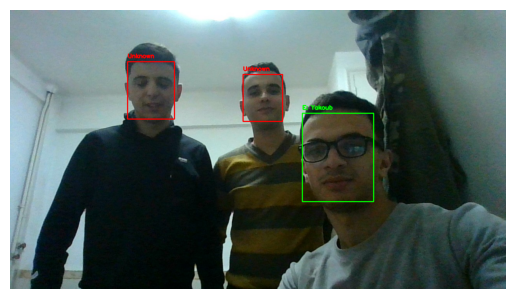

In [5]:
# Step 2: Visualize Verification Result for a New Image
image_path = "/content/test.jpg"  # Replace with the path to your new image
image = getImage(image_path)
emb=load_embeddings()
visualize_verification(image,emb)


**Evaluate the performance of the architecture using the Labeled Faces in the Wild (LFW) dataset.**

 (i pick about 100 image know and  unknown  10 image * 10 class)

# it scored an **Accuracy of 96.36%**
(i will add other metrics  recall ,Fscore ...)

In [23]:
import os

# Load stored embeddings
stored_embeddings = load_embeddings("embedding.h5")  # Update with your HDF5 file path

# Directory containing test data
test_directory = "Test"

# Initialize variables for accuracy calculation
total_verifications = 0
correct_verifications = 0
count=0
# Iterate over sub-directories in the test data
for label in os.listdir(test_directory):
    if(count>10):
      break
    print(count)
    count+=1
    label_path = os.path.join(test_directory, label)

    # Iterate over face images in the sub-directory
    for image_filename in os.listdir(label_path):
        image_path = os.path.join(label_path, image_filename)

        # Load and preprocess the face image
        new_image = getImage(image_path)
        face, _ = extract_face(new_image)

        # Ensure at least one face is detected
        if face:
            # Perform verification
            verified_employee, _ = verify_person(face[0], stored_embeddings)

            # Compare with true label
            if verified_employee == label:
                correct_verifications += 1

            total_verifications += 1
        else:
            print(f"No face detected in {image_path}. Skipping.")




# Calculate accuracy
accuracy = correct_verifications / total_verifications
print(f"Accuracy: {accuracy * 100:.2f}%")


0
1/1 [==============================] - 2s 2s/step
1
1/1 [==============================] - 1s 1s/step
2
1/1 [==============================] - 1s 1s/step
3
1/1 [==============================] - 1s 984ms/step
4
1/1 [==============================] - 1s 1s/step
5
1/1 [==============================] - 1s 992ms/step
6
1/1 [==============================] - 1s 1s/step
7
1/1 [==============================] - 1s 1s/step
8
1/1 [==============================] - 1s 1s/step
9
1/1 [==============================] - 1s 1s/step
10
1/1 [==============================] - 1s 1s/step
Accuracy: 96.36%
